In [1]:
"""
    The program is the solution I have developed for assignment 1 in DD2424, Deep Learning in Data Science at KTH. 
    @Author: Isak Gamnes Sneltvedt
    @Date (last modified): 04.04.22
"""

'\n    The program is the solution I have developed for assignment 1 in DD2424, Deep Learning in Data Science at KTH. \n    @Author: Isak Gamnes Sneltvedt\n    @Date (last modified): 04.04.22\n'

In [2]:
import numpy as np
from sklearn.metrics import precision_score, accuracy_score
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

In [3]:
def load_batch(file):
    """ Copied from: https://www.cs.toronto.edu/~kriz/cifar.html """
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
        X = dict[b'data']    # Data (3072x10000)
        Y = np.array(dict[b'labels']) # Labels as numbers
        encoded_Y = np.zeros((len(Y), np.max(Y)+1), dtype=int) 
        encoded_Y[np.arange(len(Y)), Y] = 1 # This gives each row 0 for all elements execpt for the number in each row in Y. Ex. Y = 3, encoded_Y = [0,0,0,1,0,0,0,0,0,0]
    return np.transpose(X), np.transpose(Y), np.transpose(encoded_Y) 

In [69]:
def montage(images, rows=2, cols=5):
	""" Display the image for each label in W """
	import matplotlib.pyplot as plt
	fig, ax = plt.subplots(rows,cols)
	for i in range(rows):
		for j in range(cols):
			im  = images[i*cols+j,:].reshape(32,32,3, order='F')
			sim = (im-np.min(im[:]))/(np.max(im[:])-np.min(im[:]))
			sim = sim.transpose(1,0,2)
			ax[i][j].imshow(sim, interpolation='nearest')
			ax[i][j].set_title("y="+str(cols*i+j))
			ax[i][j].axis('off')
	plt.show()

In [5]:
def normalize_data(data):
    std_data = np.std(data, axis=0)
    data = data - np.mean(data, axis=0)
    data = data / std_data
    return data

def init_params(size, mean=0, std_dev=0.01):
    W = np.random.normal(mean, std_dev, size)
    b = np.random.normal(mean, std_dev, (size[0],1))
    return W,b

def evaluate_classifier(X, W, b):
    s = np.dot(W, X) + b
    return np.exp(s)/np.sum(np.exp(s), axis=0)

def compute_cost(X, Y, W, b, lambda_val):
    P = evaluate_classifier(X, W, b)
    regularization_term = lambda_val*np.sum(np.square(W))
    D = X.shape[1]
    cross_loss = np.trace(-np.dot(np.transpose(Y), np.log(P)))
    return 1/D * cross_loss + regularization_term

def compute_accuracy(X, y, W, b):
    y_pred = np.argmax(evaluate_classifier(X, W, b), axis=0)
    return accuracy_score(y, y_pred)

def compute_gradients(X, Y, W, b, lambda_val):
    P = evaluate_classifier(X, W, b)
    batch_gradient = P - Y
    D = X.shape[1]
    grad_W = np.add(np.dot(batch_gradient,np.transpose(X)) / D , 2 * lambda_val * W)
    grad_b = np.dot(batch_gradient,np.ones((D,1))) / D
    return grad_W, grad_b

def compute_grads_num(X, Y, W, b, lambda_val, h=1**(-6)):
    no = W.shape[0]
    d = X.shape[0]

    grad_W = np.zeros(W.shape)
    grad_b = np.zeros((no, 1))

    c = compute_cost(X, Y, W, b, lambda_val)
    
    for i in range(len(b)):
        b_try = np.array(b)
        b_try[i] += h
        c2 = compute_cost(X, Y, W, b_try, lambda_val)
        grad_b[i] = (c2-c) / h

    for i in range(W.shape[0]):
        for j in range(W.shape[1]):
            W_try = np.array(W)
            W_try[i,j] += h
            c2 = compute_cost(X, Y, W_try, b, lambda_val)
            grad_W[i,j] = (c2-c) / h
    return grad_W, grad_b

def compare_computed_gradients(ga, gn, eps=1**(-7)):
    # Default eps value comes from the Standford’s course Convolutional Neural Networks for Visual Recognition recommendation 
    # https://cs231n.github.io/neural-networks-3/#gradcheck
    relative_error = np.abs(ga - gn).sum()
    denom = max(eps, np.abs(ga + gn).sum())
    if relative_error/denom < eps:
        return True
    return False

def gradient_descent(X, Y, y, X_val, Y_val, y_val, n_batch, eta, n_epochs, W, b, lambda_val):
    total_length = X.shape[1]
    training_accuracy = []
    training_loss = []
    validation_accuracy = []
    validation_loss = []
    
    for epoch in tqdm(range(n_epochs)):
        # From 0 to the total length of the data set. n_batch makes "batch" increase by n_batch (batch size) for each iteration.
        for batch in range(0, total_length, n_batch):
            max_batch_idx = batch+n_batch
            grad_W, grad_b = compute_gradients(X[:,batch:max_batch_idx], Y[:,batch:max_batch_idx], W, b, lambda_val)
            W -= eta*grad_W
            b -= eta*grad_b 
        
        """ Weight decay """
        if epoch%10 == 0 and epoch!=0:
            eta = .1*eta
            tqdm.write('Weight decay performed.. eta is now {}'.format(eta))
                  
        training_accuracy.append(compute_accuracy(X, y, W, b))
        training_loss.append(compute_cost(X, Y, W, b, lambda_val))
        validation_accuracy.append(compute_accuracy(X_val, y_val, W, b))
        validation_loss.append(compute_cost(X_val, Y_val, W, b, lambda_val)) 
    return W, b, training_accuracy, training_loss, validation_accuracy, validation_loss

def plot_training_validation(training, validation, plot_accuracy=True):
    if plot_accuracy:
        plotting = 'Accuracy'
    else:
        plotting = 'Loss'
    plt.plot(training, color='red', label='Train ' + plotting)
    plt.plot(validation, color='blue', label='Validation ' + plotting)
    
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel(plotting)
    plt.show()

In [32]:
train_x, train_Y, train_encoded_Y = load_batch('../Datasets/cifar-10-batches-py/data_batch_1')
validation_x, validation_Y, validation_encoded_Y = load_batch('../Datasets/cifar-10-batches-py/data_batch_2')
test_x, test_Y, test_encoded_Y = load_batch('../Datasets/cifar-10-batches-py/data_batch_3')

In [33]:
train_normalized = normalize_data(train_x)
validation_normalized = normalize_data(validation_x)
test_normalized = normalize_data(test_x)

In [8]:
W, b = init_params((10,3072))

In [9]:
print(W.shape, b.shape)

(10, 3072) (10, 1)


In [10]:
# Testing that the prediction works as inteded
P=evaluate_classifier(train_normalized,W,b) # Should give (10, 1000) with probabilities for each label class
print(P.shape, P[:,0]) # Prints the shape and the first prediction

(10, 10000) [0.05457125 0.07294942 0.0881379  0.1750576  0.08444427 0.09355625
 0.1441921  0.05765798 0.06207609 0.16735715]


In [11]:
# Testing gradient computation
g_W,g_b=compute_grads_num(train_normalized[:,:50], train_encoded_Y[:,:50], W, b, 0)
G_W,G_b=compute_gradients(train_normalized, train_encoded_Y, W, b, 0)
comparison = compare_computed_gradients(g_b, G_b)
if comparison:
    print('Returned true. Gradients have produced the same result')
else:
    print('Failed..')

Returned true. Gradients have produced the same result


In [12]:
W, b, training_accuracy, training_loss, validation_accuracy, validation_loss = gradient_descent(train_normalized, train_encoded_Y, train_Y, validation_normalized, validation_encoded_Y, validation_Y, n_batch=100, eta=.001, n_epochs=40, W=W, b=b, lambda_val=1)

 25%|██▌       | 10/40 [00:40<02:02,  4.08s/it]

Weight decay performed.. eta is now 0.0001


 50%|█████     | 20/40 [01:17<01:14,  3.72s/it]

Weight decay performed.. eta is now 1e-05


 75%|███████▌  | 30/40 [01:54<00:37,  3.73s/it]

Weight decay performed.. eta is now 1.0000000000000002e-06


100%|██████████| 40/40 [02:32<00:00,  3.81s/it]


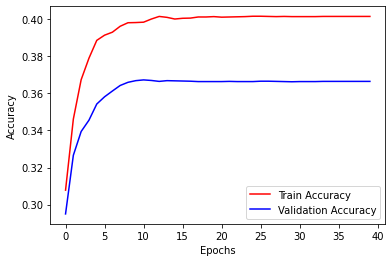

In [13]:
plot_training_validation(training_accuracy, validation_accuracy, plot_accuracy=True)

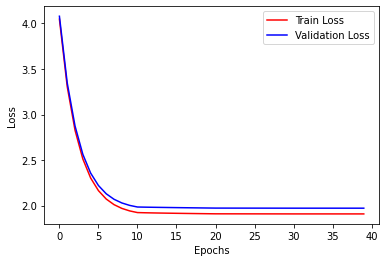

In [14]:
plot_training_validation(training_loss, validation_loss, plot_accuracy=False)

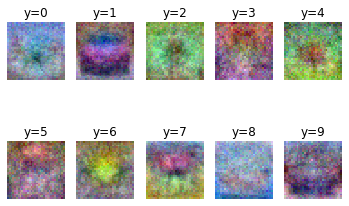

In [15]:
montage(W)

In [16]:
P=evaluate_classifier(test_normalized,W,b)

In [61]:
print(train_x.shape)
print(train_x[:,1])

(3072, 10000)
[154 126 105 ... 139 142 144]


In [67]:
x1 = np.flip(train_x, axis=0)
x2 = np.flip(train_x, axis=1)
x3 = np.flip(train_x, axis=(0,1))

In [60]:
print(x1.shape)
print(x1[:,1])

(3072, 10000)
[144 142 139 ... 105 126 154]


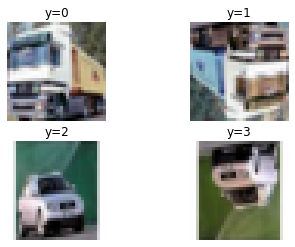

In [70]:
test_images = np.array([train_x[:,1],x1[:,1],x2[:,1],x3[:,1]])
montage(test_images,2,2)